# CRYPTOviz - a pipeline for cryptocurrency price forcasting using deep learning.

A research based project that defines a AI pipeline for cryptocurrency price trend prediction that is compatible with modern trading strategies. The cryptocurrencies that are considered here are:
* Ethereum
* Bitcoin
* Litecoin
* Bitcoin cash

## Exploratory Data Analysis

## Ethereum

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
df = pd.read_csv('ETH-USD.csv', names=['time', 'low', 'high', 'open', 'close', 'volume'])
df.head(3)

,time,low,high,open,close,volume
0,1528968720,485.98999,486.5,486.019989,486.01001,26.019083
1,1528968780,486.00000,486.0,486.000000,486.00000,8.449400
2,1528968840,485.75000,486.0,486.000000,485.75000,26.994646


In [4]:
df.describe()

,time,low,high,open,close,volume
count,1.028310e+05,102831.000000,102831.000000,102831.000000,102831.000000,102831.000000
mean,1.532082e+09,421.568149,421.881633,421.731671,421.731915,56.358570
std,1.808513e+06,74.764506,74.747915,74.754349,74.756375,153.698708
min,1.528969e+09,250.279999,252.490005,251.259995,251.000000,0.000030
25%,1.530515e+09,398.790009,399.574997,399.235001,399.100006,5.483059
50%,1.532062e+09,449.149994,449.380005,449.299988,449.309998,15.543176
75%,1.533669e+09,470.809998,471.170013,471.000000,471.000000,46.392617
max,1.535215e+09,545.159973,547.400024,547.000000,547.000000,9310.024414


It is seen that (low, high, open, close) values are similar since we're taking minutewise data. 

We plot a correlation matrix :
The correlation coefficient is a value that indicates the strength of the relationship.The coefficient can take any values from -1 to 1. The interpretations of the values are:

**-1**: Perfect negative correlation. The variables tend to move in opposite directions (i.e., when one variable increases, the other variable decreases).

**0:** No correlation. The variables do not have a relationship with each other.

**1:** Perfect positive correlation. The variables tend to move in the same direction (i.e., when one variable increases, the other variable also increases).

**Correlation between 2 variables x and y is given by:**

![](https://cdn.corporatefinanceinstitute.com/assets/correlation1.png)

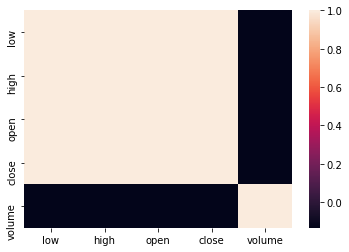

In [5]:
dfc = df.set_index('time')
sns.heatmap(dfc.corr())

So, we can choose volume and any one of (low, high, open, close). We choose **volume** and **close** to train our model.

In [6]:
#converting unix timestamp to date for eda
df['time']=pd.to_datetime(df['time'],unit='s')

In [7]:
print (df.dtypes)

time      datetime64[ns]
low              float64
high             float64
open             float64
close            float64
volume           float64
dtype: object


Our target variable is **close** so we have do a time series analysis on it.

In [8]:
df1 = df[['time','close']]
df1.head(3)

,time,close
0,2018-06-14 09:32:00,486.01001
1,2018-06-14 09:33:00,486.00000
2,2018-06-14 09:34:00,485.75000


In [9]:
# Setting the Date as Index
df_ts = df1.set_index('time')
df_ts.sort_index(inplace=True)
print (type(df_ts))
print (df_ts.head(3))
print (df_ts.tail(3))

<class 'pandas.core.frame.DataFrame'>
                         close
time                          
2018-06-14 09:32:00  486.01001
2018-06-14 09:33:00  486.00000
2018-06-14 09:34:00  485.75000
                          close
time                           
2018-08-25 16:39:00  279.660004
2018-08-25 16:40:00  279.649994
2018-08-25 16:41:00  279.649994


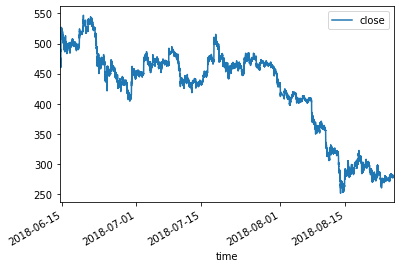

In [10]:
#plot
df_ts.plot()

### Checking for stationarity

A stationary series is one in which the properties – mean, variance and covariance, do not vary with time.
Suppose we have a time series :

**y<sub>t</sub> = a * y<sub>t-1</sub> + ε<sub>t</sub>**

where y<sub>t</sub> is the value at the time instant t and ε<sub>t</sub> is the error term. In order to calculate y<sub>t</sub> we need the value of y<sub>t-1</sub>, which is :

**y<sub>t-1</sub> = a * y<sub>t-2</sub> + ε<sub>t-1</sub>**

If we do that for all observations, the value of y<sub>t</sub> will come out to be:

**y<sub>t</sub> = a<sup>n</sup> * y<sub>t-n</sub> + Σε<sub>t-i</sub> *a<sup>i</sup>**

If the value of a is 1 (unit) in the above equation, then the predictions will be equal to the y<sub>t-n</sub> and sum of all errors from t-n to t, which means that the variance will increase with time. This is knows as unit root in a time series. We know that for a stationary time series, the variance must not be a function of time. The unit root tests check the presence of unit root in the series by checking if value of a=1. 

### Dickey Fuller test

**Null Hypothesis:** The series has a unit root (value of a =1)

**Alternate Hypothesis:** The series has no unit root.

If we fail to reject the null hypothesis, we can say that the series is non-stationary. 

In [11]:
def dickey_fuller_test(timeseries):
    
    print('Results of Dickey-Fuller Test:')
       
    dftest = adfuller(timeseries, autolag='AIC')
    
    adf_result = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
    
    for key, value in dftest[4].items():
        adf_result['Critical Value (%s)'%key] = value
    
    print(adf_result)

In [12]:
# Create a time series for close
ts = df_ts['close']
# Stationarity with Dickey Fuller Test
dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                     -0.382967
p-value                             0.912904
#lags Used                         63.000000
Number of Observations Used    102767.000000
Critical Value (1%)                -3.430414
Critical Value (5%)                -2.861568
Critical Value (10%)               -2.566785
dtype: float64


**Test for stationarity:** If the test statistic is less than the critical value, we can reject the null hypothesis (aka the series is stationary). When the test statistic is greater than the critical value, we fail to reject the null hypothesis (which means the series is not stationary).

**Conclusion from adf test:** Test Statistic> Critical Value, therefore, we fail to reject the null hypothesis,i.e, the time series is non-stationary.

### KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test

Null Hypothesis: The process is trend stationary.

Alternate Hypothesis: The series has a unit root (series is not stationary).

In [13]:
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [14]:
# Stationarity with Dickey Fuller Test
kpss_test(ts)

Results of KPSS Test:
Test Statistic           106.588723
p-value                    0.010000
Lags Used                 68.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


**Test for stationarity:** If the test statistic is greater than the critical value, we reject the null hypothesis (series is not stationary). If the test statistic is less than the critical value, if fail to reject the null hypothesis (series is stationary).

**Conclusion from kpss test:** Test Statistic> Critical Value, therefore, we reject the null hypothesis,i.e,the time series is non-stationary.

**Case 1:** Both tests conclude that the series is not stationary -> series is not stationary

**Case 2:** Both tests conclude that the series is stationary -> series is stationary

**Case 3:** KPSS = stationary and ADF = not stationary  -> trend stationary, remove the trend to make series strict stationary

**Case 4:** KPSS = not stationary and ADF = stationary -> difference stationary, use differencing to make series stationary

**Conclusion:** Our time series is non-stationary(Case1).

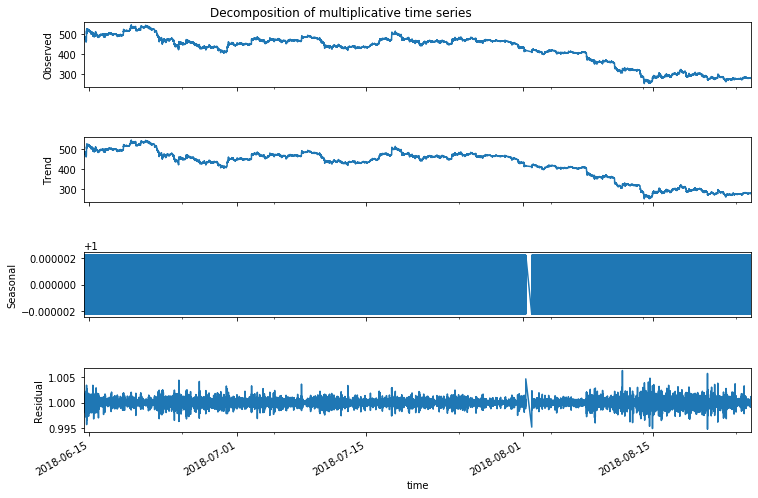

In [15]:
# not needed in our case, only for case 3 and 4
decomposition = sm.tsa.seasonal_decompose(ts, model='multiplicative', freq=2)

fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of multiplicative time series')
plt.show()

### Conversion to stationary time series

We have to convert our time series into a stationary series. We can use any of these methods:

* Differencing

  **y<sub>t</sub><sup>‘</sup> = y<sub>t</sub> – y<sub>t-1</sub>**
  
* Seasonal differencing

  **y<sub>t</sub><sup>‘</sup> = y<sub>t</sub> – y<sub>t-n</sub>**
  
* Transformation
  
  **y<sub>t</sub><sup>‘</sup> = log(y<sub>t</sub>) – y<sub>t-1</sub>**
     

In [16]:
#applying transformation
tsmlog = np.log10(ts)
tsmlog.dropna(inplace=True)

tsmlogdiff = ts.diff(periods=1)
tsmlogdiff.dropna(inplace=True)

In [17]:
# Stationarity Check
dickey_fuller_test(tsmlogdiff)
print("*"*50)
kpss_test(tsmlogdiff)

Results of Dickey-Fuller Test:
Test Statistic                    -39.716975
p-value                             0.000000
#lags Used                         62.000000
Number of Observations Used    102767.000000
Critical Value (1%)                -3.430414
Critical Value (5%)                -2.861568
Critical Value (10%)               -2.566785
dtype: float64
**************************************************
Results of KPSS Test:
Test Statistic            0.130681
p-value                   0.100000
Lags Used                68.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


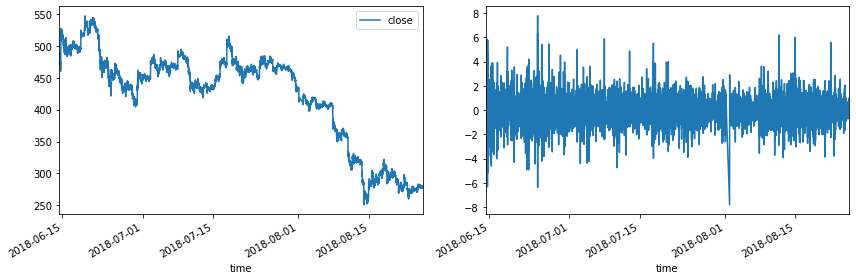

In [18]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
df_ts.plot(ax=axes[0])
tsmlogdiff.plot(ax=axes[1])
plt.tight_layout()

**The time series is stationary now. We can use it for deep learning**

### Finally, insights from EDA

* Since **(low, high, open, close)** are having similar values, we can choose any one instead of all.
* **Volume** is negatively correlated, so we choose that as another parameter.
* Due to volatility of cryptocurrency prices, the timeseries of **close** is non-stationary. We need to apply transformations to make the series stationary before using it any algorithm.
 